In [0]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalMaxPooling1D, Flatten, Conv1D, Dropout, Activation
from keras.preprocessing.text import Tokenizer

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from wordcloud import WordCloud
from torchtext import data

In [0]:
import nltk
import torch
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [0]:
import os
import re
import string

from tensorflow import set_random_seed
from numpy.random import seed
seed(1)
set_random_seed(2)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def getLines(inFile):
    fr = open(inFile,'r') 
    myList=[]
    for line in fr :
        myList.append(line.strip())
    fr.close()
    return myList

In [0]:
reviewList = getLines("/content/gdrive/My Drive/Colab Notebooks/SentimentAnalysis/reviews_imdb.txt")
labelList = getLines ("/content/gdrive/My Drive/Colab Notebooks/SentimentAnalysis/labels.txt")

In [0]:
#remove all stopwords from reviews and make it crisp

english_stopwords = set(nltk.corpus.stopwords.words('english'))

for x in range(0, len(reviewList)-1):
  stop_tokens = word_tokenize(reviewList[x].replace('.', ''))
  content_tokens = [token for token in stop_tokens if token.lower() not in english_stopwords]
  reviewList[x] = ' '.join(map(str, content_tokens))

In [6]:
#creating 2 dataframes for reviews and labels, also another with concat those two

review_df = pd.DataFrame({'text':reviewList})
label_df = pd.DataFrame({'label':labelList})

data = pd.concat([label_df, review_df], axis=1)
data.columns = ['label', 'text']

data.head()

,label,text
0,positive,bromwell high cartoon comedy ran time programs...
1,negative,story man unnatural feelings pig starts openin...
2,positive,homelessness houselessness george carlin state...
3,negative,airport starts brand new luxury plane loaded v...
4,positive,brilliant acting lesley ann warren best dramat...


In [0]:
#separating positives and negatives

data_pos = data[ data['label'] == 'positive']
data_pos = data_pos['text']

data_neg = data[ data['label'] == 'negative']
data_neg = data_neg['text']

In [0]:
#wordcloud for words distributed in positive and negative review, more the word appears bigger the word displays

def wordcloud_draw(data):
    words = ' '.join(map(str, data))
    wordcloud = WordCloud(background_color='white', width=2500, height=2000).generate(words)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

Positive Words


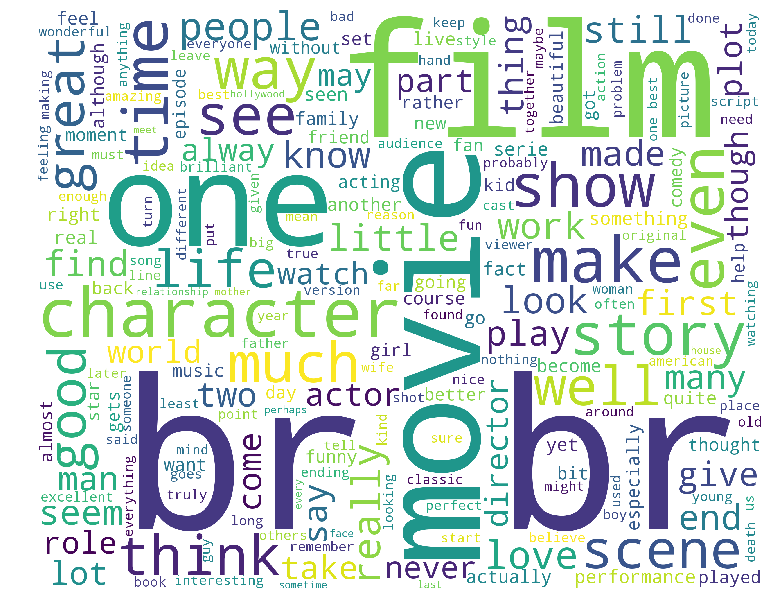

In [9]:
#calling wordcloud for positive

print("Positive Words")
wordcloud_draw(data_pos)

Negative Words


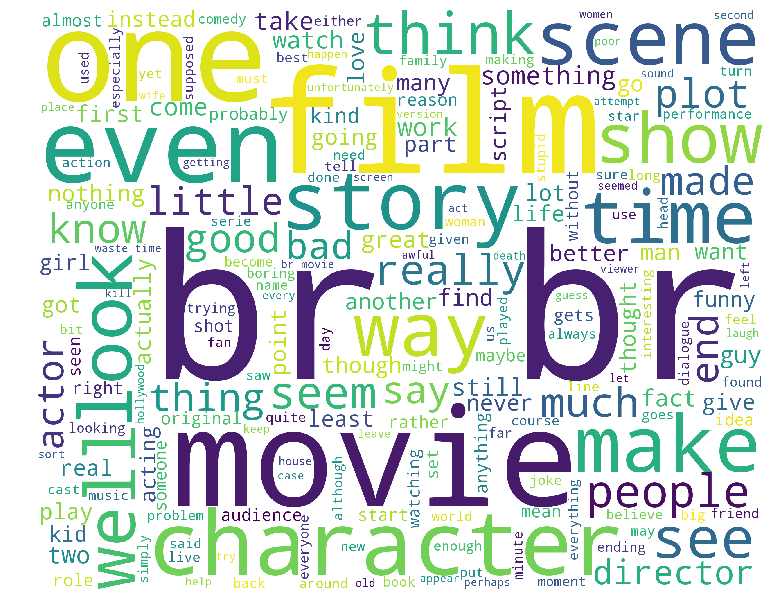

In [10]:
#calling wordcloud for negatives

print("Negative Words")
wordcloud_draw(data_neg)

In [0]:
#Field defines how the data should be processed, here the data consists of both the raw string of the review and the sentiment, either positive or negative
#REVIEW field has tokenize='spacy' which means tokenization should be done using the spaCy tokenizer. 

REVIEW = data.Field(tokenize='spacy')
LABEL = data.LabelField(dtype=torch.float)

In [0]:
#splitting data into training and test sets

tokenized_sents = [word_tokenize(i) for i in reviewList]
tokWords = pd.DataFrame(tokenized_sents)

tokenized_categories = [word_tokenize(i) for i in labelList]
tokLabels = pd.DataFrame(tokenized_categories)

X_train, X_test, y_train, y_test = train_test_split(tokenized_sents, tokenized_categories, test_size=0.3)

In [16]:
print(f'Number of training examples: {len(X_train)}')
print(f'Number of testing examples: {len(X_test)}')

Number of training examples: 17500
Number of testing examples: 7500


In [0]:
#building a vocabulary, this is a effectively a look up table where every unique word in the data set has a corresponding index
#only keeping the most common max_size tokens

REVIEW.build_vocab(X_train, max_size=25000)
LABEL.build_vocab(y_train)

In [18]:
print(f"Unique tokens in TEXT vocabulary: {len(REVIEW.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [19]:
#most common 20 words in the dataset

print(REVIEW.vocab.freqs.most_common(20))

[('br', 71255), ('movie', 30804), ('film', 28445), ('one', 18734), ('like', 14162), ('good', 10656), ('time', 8905), ('even', 8842), ('would', 8800), ('story', 8396), ('really', 8257), ('see', 8057), ('well', 7501), ('much', 6827), ('bad', 6619), ('get', 6527), ('great', 6448), ('people', 6448), ('also', 6386), ('first', 6341)]


In [0]:
#getting the vocabulary directly using either the itos method, and saving it in a variable

vocab_list = REVIEW.vocab.itos[:]

In [0]:
#storing the vocabulary in a dataframe

vocab_df = pd.DataFrame(vocab_list)
#vocab_df.head()

In [0]:
#one hot encoding for all the words in test sample

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(vocab_df)

enc.transform(vocab_df)

onehot = enc.fit_transform(vocab_df)

In [0]:
#taking the onehot into an array
onehot_array = onehot.toarray()

#onehot array into a dataframe so it can be viewed nicely
onehot_df = pd.DataFrame(onehot_array)

In [24]:
onehot_df

,0,1,2,3,4,5,6,7,8,9,...,24992,24993,24994,24995,24996,24997,24998,24999,25000,25001
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
#from array to torch

onehot_torch = torch.from_numpy(onehot_array)
onehot_torch = onehot_torch.to(dtype=torch.float)

In [26]:
#converting y_train into a 0 or 1 values and making a torch

y_train_df = pd.Series( (v[0] for v in y_train) )
y_train_binary = pd.get_dummies(y_train_df, drop_first=True)
y_train_matrix = y_train_binary.as_matrix()

y_train_flatten = y_train_matrix.ravel()
#y_train_flatten

y_train_torch = torch.FloatTensor(y_train_flatten)
y_train_torch

tensor([0., 0., 0.,  ..., 0., 1., 1.])

In [27]:
import torch

# N is batch size (e.g. the number of training examples) 
# D_in is input dimension;
# H is hidden dimension; 
# D_out is output dimension.
N, D_in, H, D_out = 17500, 25002, 25, 1

# Create random Tensors to hold inputs and outputs.
#x = torch.randn(N, D_in)
#y = torch.randn(25002, D_out)
x = onehot_torch
y = y_train_torch

# Use the nn package to define our model and loss function.
#nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
#torch.nn.Linear =Applies a linear transformation to the incoming data, i.e. //y= Ax+b//. 
#torch.nn.RELU =applies RELU activation function
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, H),
          torch.nn.ReLU(),
          torch.nn.Linear(H, D_out),
        )
loss_fn = torch.nn.MSELoss(reduction='sum')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(3):
  # Forward pass: compute predicted y by passing x to the model.
  y_pred = model(x)
  #print(y_pred)

  # Compute and print loss.
  loss = loss_fn(y_pred, y)
  print(t, loss.item())
  
  # Before the backward pass, use the optimizer object to zero all of the
  # gradients for the Tensors it will update (which are the learnable weights
  # of the model)
  optimizer.zero_grad()

  # Backward pass: compute gradient of the loss with respect to model parameters
  loss.backward()

  # Calling the step function on an Optimizer makes an update to its parameters
  optimizer.step()

0 150313632.0
1 150220640.0
2 150128528.0


**trying anothe way**

In [28]:
label_df = pd.get_dummies(label_df['label'], drop_first=True)

data = pd.concat([label_df, review_df], axis=1)
data.columns = ['label', 'text']

data.head()

,label,text
0,1,bromwell high cartoon comedy ran time programs...
1,0,story man unnatural feelings pig starts openin...
2,1,homelessness houselessness george carlin state...
3,0,airport starts brand new luxury plane loaded v...
4,1,brilliant acting lesley ann warren best dramat...


In [0]:
#setting hyperparameters for training our model

BATCH_SIZE = 128 #number of examples used in each iteration
EPOCHS = 2 #number of passes through entire dataset
VOCAB_SIZE = 25000 #size of vocabulary dictionary
MAX_LEN = 500 #max length of review (in words)
EMBEDDING_DIM = 400 #dimension of word embedding vector

NUM_FILTERS = 250
KERNEL_SIZE = 3
HIDDEN_DIMS = 20

In [0]:
#splitting data into training and validation sets

#train = data[:17499]
#val = data[17500:]

train = data
val = data

In [31]:
#here the Keras Tokenizer converts each word to a corresponding integer ID

LABELS = ['negative', 'positive']

imdb_tokenizer = Tokenizer(num_words=VOCAB_SIZE)
imdb_tokenizer.fit_on_texts(train['text'].values)

x_train_seq = imdb_tokenizer.texts_to_sequences(train['text'].values)
x_val_seq = imdb_tokenizer.texts_to_sequences(val['text'].values)


#in order to feed the text into our CNN, all texts should be the same length, ensure this using the sequence.pad_sequences() method and MAX_LEN variable
x_train = sequence.pad_sequences(x_train_seq, maxlen=MAX_LEN, padding="post", value=0)
x_val = sequence.pad_sequences(x_val_seq, maxlen=MAX_LEN, padding="post", value=0)

y_train, y_val = train['label'].values, val['label'].values

print('First sample before preprocessing: \n', train['text'].values[0], '\n')
print('First sample after preprocessing: \n', x_train[0])

First sample before preprocessing: 
 bromwell high cartoon comedy ran time programs school life teachers years teaching profession lead believe bromwell high satire much closer reality teachers scramble survive financially insightful students see right pathetic teachers pomp pettiness whole situation remind schools knew students saw episode student repeatedly tried burn school immediately recalled high classic line inspector sack one teachers student welcome bromwell high expect many adults age think bromwell high far fetched pity 

First sample after preprocessing: 
 [20871   194   914   102  1998     7  5641   264    34  5051    59  4832
  5708   352   148 20871   194  1838    14  2255   485  5051 23948  1843
 10016  5642  1362    12    99  1062  5051 19716   115   749  2848  5643
   558  1362   110   265  1270  3544   650  3341   264  1075 13431   194
   233   225  2774  7544     4  5051  1270  2186 20871   194   404    33
  1312   418    26 20871   194   120  4004  2071     0     0

In [33]:
# CNN Model
print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into EMBEDDING_DIM dimensions
model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn NUM_FILTERS filters
model.add(Conv1D(NUM_FILTERS,
                 KERNEL_SIZE,
                 padding='valid',
                 activation='relu',
                 strides=1))

# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(HIDDEN_DIMS))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Build model...


In [34]:
# fit a model and i have set the epochs for 2 earlier
model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_split=0.1,
          verbose=2)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 22500 samples, validate on 2500 samples
Epoch 1/2
 - 24s - loss: 0.4806 - acc: 0.7624 - val_loss: 0.3407 - val_acc: 0.8536
Epoch 2/2
 - 20s - loss: 0.2288 - acc: 0.9148 - val_loss: 0.3425 - val_acc: 0.8560


In [35]:
# Evaluate the model
score, acc = model.evaluate(x_val, y_val, batch_size=BATCH_SIZE)
print('\nAccuracy: ', acc*100)

pred = model.predict_classes(x_val)

25000/25000 [==============================] - 5s 215us/step

Accuracy:  96.8799999961853


In [36]:
# Print Precision Recall F1-Score Report

report = classification_report(pred, y_val, target_names=LABELS)
print(report)

              precision    recall  f1-score   support

    negative       0.96      0.98      0.97     12320
    positive       0.98      0.96      0.97     12680

   micro avg       0.97      0.97      0.97     25000
   macro avg       0.97      0.97      0.97     25000
weighted avg       0.97      0.97      0.97     25000



In [37]:
print(confusion_matrix(pred, y_val))

[[12020   300]
 [  480 12200]]
